<a href="https://colab.research.google.com/github/waleedGeorgy/deep-learning/blob/main/Deep_Learning_Models_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting set up

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 33.04 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# Training the model we will deploy

The model we'll deploy will be trained on the "pizza steak sushi 20%" dataset.

Using this dataset, we will train two models that previously showed great results for our use-case. These models are: **EfficientNetB2** and the **ViT-B/16** feature extractors.

Our goal is get a model that is accurate (e.g. +95% accuracy) and almost instantaneous (when making predictions).

## EfficientNetB2 feature extractor

In [5]:
# A class to creat an EffnetB2 model and transforms
def create_effnetb2(num_class: int,
                    seed: int = 42):
  """
  A class to create an EfficientNetB2 feature extractor with DEFAULT weights

  Args:
    num_class (int): number of classes in the classifier head (int).
    seed (int): random seed values (int, default = 42)

  Returns:
    model (torch.nn.Module): an instance of the EfficientNetB2 feature extractor with DEFAULT weights.
    transforms (torchvision.transforms): an instant of the EfficientNetB2 transforms
  """
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for param in model.features.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_class, bias = True)
  )

  return model, transforms

In [6]:
effnetb2, effnetb2_transforms = create_effnetb2(num_class=3,
                                                seed = 42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 49.1MB/s]


In [7]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
summary(model = effnetb2,
        input_size = (32,3,288,288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

In [9]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

class_names

['pizza', 'steak', 'sushi']

In [10]:
# Setting up the training
from going_modular.going_modular import engine
from timeit import default_timer as timer

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_start = timer()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)
effnetb2_end = timer()
effnetb2_train_time = effnetb2_end - effnetb2_start
print(f'[INFO] Total training time: {effnetb2_train_time:.2f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9794 | train_acc: 0.5708 | test_loss: 0.7390 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6835 | train_acc: 0.8771 | test_loss: 0.5929 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5640 | train_acc: 0.8958 | test_loss: 0.4816 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4716 | train_acc: 0.8729 | test_loss: 0.4183 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.4308 | train_acc: 0.8729 | test_loss: 0.3723 | test_acc: 0.9659
Epoch: 6 | train_loss: 0.3738 | train_acc: 0.8979 | test_loss: 0.3456 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.3373 | train_acc: 0.9062 | test_loss: 0.3132 | test_acc: 0.9568
Epoch: 8 | train_loss: 0.3248 | train_acc: 0.9250 | test_loss: 0.3009 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3671 | train_acc: 0.8562 | test_loss: 0.2747 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.2564 | train_acc: 0.9458 | test_loss: 0.2649 | test_acc: 0.9597
[INFO] Total training time: 1765.60 seconds


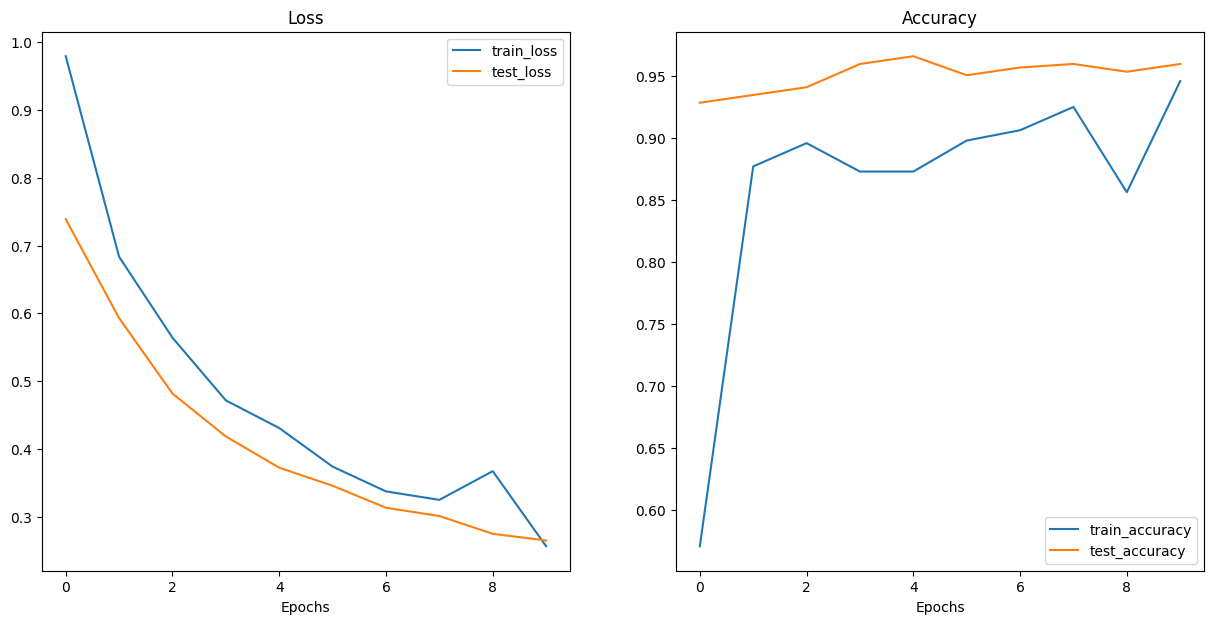

In [11]:
# Plotting the loss and accuracy curves
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [12]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2.pth")

[INFO] Saving model to: models/effnetb2.pth


Another "parameter" we need to take into account is model's size in megabytes.

The EfficientNetB2 feature extractor is about 30 MBs, which is relatively small, especially in the context of our application.

In [13]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [14]:
# Saving model's results to a dictionary
from pathlib import Path

effnetb2_numbers = {'test_loss' : effnetb2_results['test_loss'][-1],
                    'test_accuracy' : effnetb2_results['test_acc'][-1],
                    'total_params' : effnetb2_total_params,
                    'training_time' : effnetb2_train_time,
                    'model_size' : Path("/content/models/effnetb2.pth").stat().st_size // (1024*1024)}

In [15]:
effnetb2_numbers

{'test_loss': 0.2649004518985748,
 'test_accuracy': 0.959659090909091,
 'total_params': 7705221,
 'training_time': 1765.604836038,
 'model_size': 29}

## ViT-B/16 feature extractor

In [ ]:
# Creating the ViT-B/16 model and transforms
def create_vitb16(num_class:int = 3, seed:int = 42):
  """
  A class to create a ViT-B/16 feature extractor with DEFAULT weights

  Args:
    num_class (int): number of classes in the classifier head (int).
    seed (int): random seed values (int, default = 42)

  Returns:
    model (torch.nn.Module): an instance of the ViT-B/16 feature extractor with DEFAULT weights.
    transforms (torchvision.transforms): an instant of the ViT-B/16 transforms
  """
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_class))

  return model, transforms

In [ ]:
vitb16, vitb16_transforms = create_vitb16()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 128MB/s]


In [ ]:
summary(model = vitb16,
        input_size = (1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vitb16, test_dataloader_vitb16, class_names_vitb16 = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=vitb16_transforms,
                                                                                                 batch_size=32)

class_names_vitb16

['pizza', 'steak', 'sushi']

In [ ]:
# Setting up the training
from going_modular.going_modular import engine
from timeit import default_timer as timer

optimizer = torch.optim.Adam(params=vitb16.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

vitb16_start = timer()

vitb16_results = engine.train(model=vitb16,
                              train_dataloader=train_dataloader_vitb16,
                              test_dataloader=test_dataloader_vitb16,
                              epochs=10,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              device=device)

vitb16_end = timer()

vitb16_train_time = vitb16_end - vitb16_start

print(f'[INFO] Total training time: {vitb16_train_time:.2f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
[INFO] Total training time: 85.87 seconds


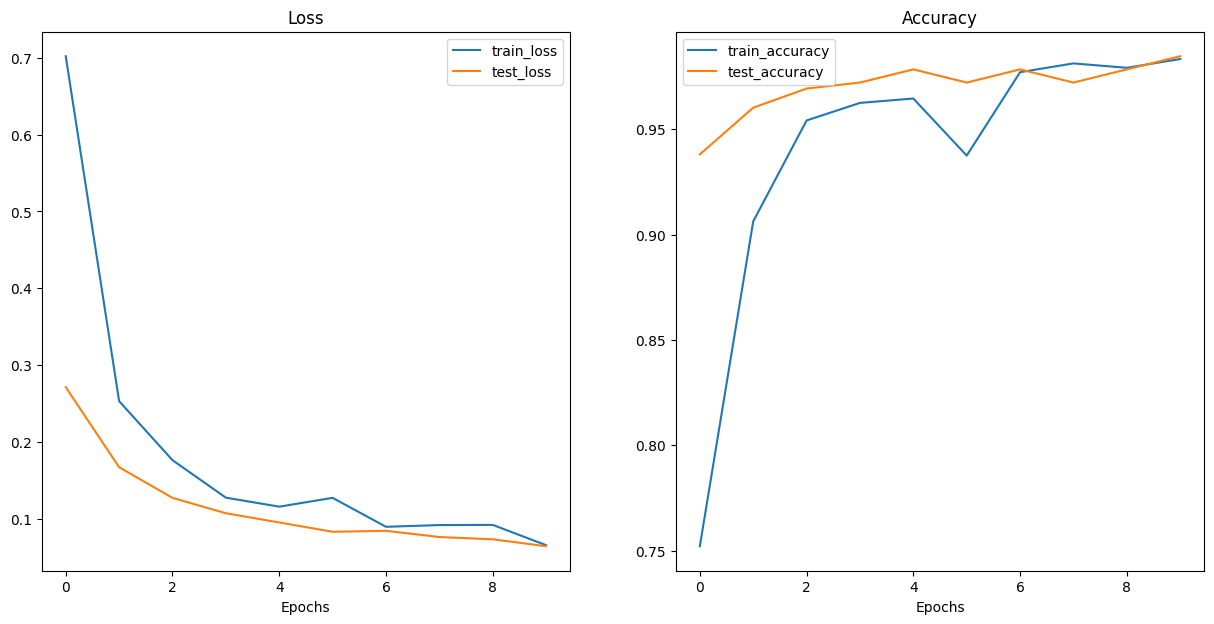

In [ ]:
# Plotting the loss and accuracy curves
from helper_functions import plot_loss_curves

plot_loss_curves(vitb16_results)

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=vitb16,
                 target_dir="models",
                 model_name="vitb16.pth")

[INFO] Saving model to: models/vitb16.pth


In [ ]:
# Count number of parameters in EffNetB2
vitb16_total_params = sum(torch.numel(param) for param in vitb16.parameters())
vitb16_total_params

85800963

In [ ]:
# Saving model's results to a dictionary
from pathlib import Path

vitb16_numbers = {'test_loss' : vitb16_results['test_loss'][-1],
                    'test_accuracy' : vitb16_results['test_acc'][-1],
                    'total_params' : vitb16_total_params,
                    'training_time' : vitb16_train_time,
                    'model_size' : Path("/content/models/vitb16.pth").stat().st_size // (1024*1024)}

vitb16_numbers

{'test_loss': 0.06443451717495918,
 'test_accuracy': 0.984659090909091,
 'total_params': 85800963,
 'training_time': 85.871526717,
 'model_size': 327}

In [ ]:
effnetb2_numbers

{'test_loss': 0.28108686208724976,
 'test_accuracy': 0.9625,
 'total_params': 7705221,
 'training_time': 58.71461634100001,
 'model_size': 29}

# Comparing models' performance

As we outlined previously, we want our models to have high accuracy (+95% accuracy) and to make almost instantaneous predictions (~ 0.03 seconds).

The first criteria has been met with both of the models. Next, we will evaluate how fast said models can make predictions

In [ ]:
# Getting the list of test images
test_img_list = list(Path(test_dir).glob('*/*.jpg'))
img = torchvision.io.read_image(str(test_img_list[0]))
img.shape

torch.Size([3, 384, 512])

In [ ]:
# Calculating mean prediction time using EfficientNetB2
import PIL

set_seeds()

effnetb2_total_time = 0

for img_path in test_img_list:

  start_time = timer()

  img = torchvision.io.read_image(str(img_path))
  transformed_img = effnetb2_transforms(img).unsqueeze(0).to(device)

  effnetb2.eval()
  with torch.inference_mode():

    y_logits = effnetb2(transformed_img)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  end_time = timer()

  pred_time = end_time - start_time
  effnetb2_total_time += pred_time

mean_pred_time_effnetb2 = round(effnetb2_total_time / len(test_img_list), 4)
print(f'Total prediction time on the test data using EfficientNetB2: {effnetb2_total_time:.4f} seconds')
print(f'Mean prediction time using EfficientNetB2 feature extractor: {mean_pred_time_effnetb2} seconds')

Total prediction time on the test data using EfficientNetB2: 3.2524 seconds
Mean prediction time using EfficientNetB2 feature extractor: 0.0217 seconds


In [ ]:
# Calculating mean prediction time using ViT-B/16
set_seeds()

vitb16_total_time = 0

for img_path in test_img_list:

  start_time = timer()

  img = torchvision.io.read_image(str(img_path))
  transformed_img = vitb16_transforms(img).unsqueeze(0).to(device)

  vitb16.eval()
  with torch.inference_mode():

    y_logits = vitb16(transformed_img)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  end_time = timer()
  pred_time = end_time - start_time
  vitb16_total_time += pred_time

mean_pred_time_vitb16 = round(vitb16_total_time / len(test_img_list), 4)
print(f'Total prediction time on the test data using ViT-B/16: {vitb16_total_time:.4f} seconds')
print(f'Mean prediction time using ViT-B/16 feature extractor: {mean_pred_time_vitb16:} seconds')

Total prediction time on the test data using ViT-B/16: 2.2503 seconds
Mean prediction time using ViT-B/16 feature extractor: 0.015 seconds


In [ ]:
# Apeending mean pred times to existing models performances dictionaries
effnetb2_numbers['mean_pred_time'] = mean_pred_time_effnetb2
vitb16_numbers['mean_pred_time'] = mean_pred_time_vitb16

# Adding models' names for reference
effnetb2_numbers['model'] = 'EfficientNetB2'
vitb16_numbers['model'] = 'ViT-B/16'

In [ ]:
# Turning models' performance results into a dataframe for readability
import pandas as pd
effnetb2_df = pd.DataFrame([effnetb2_numbers])
vitb16_df = pd.DataFrame([vitb16_numbers])

In [ ]:
# Combining the two dataframes into a single one
models_df = pd.concat([effnetb2_df, vitb16_df], axis = 0)

In [ ]:
# Adjusting some of the values for readability
models_df['test_accuracy'] = round(models_df['test_accuracy']*100, 2)
models_df['test_loss'] = round(models_df['test_loss'], 4)
models_df['training_time'] = round(models_df['training_time'], 2)

In [ ]:
models_df

,test_loss,test_accuracy,total_params,training_time,model_size,mean_pred_time,model
0,0.2811,96.25,7705221,58.71,29,0.0217,EfficientNetB2
0,0.0644,98.47,85800963,85.87,327,0.0150,ViT-B/16


In [ ]:
# Comparing ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(models_df.set_index("model").loc["ViT-B/16"] / models_df.set_index("model").loc["EfficientNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_accuracy,total_params,training_time,model_size,mean_pred_time
ViT to EffNetB2 ratios,0.2291,1.023065,11.135432,1.462613,11.275862,0.691244


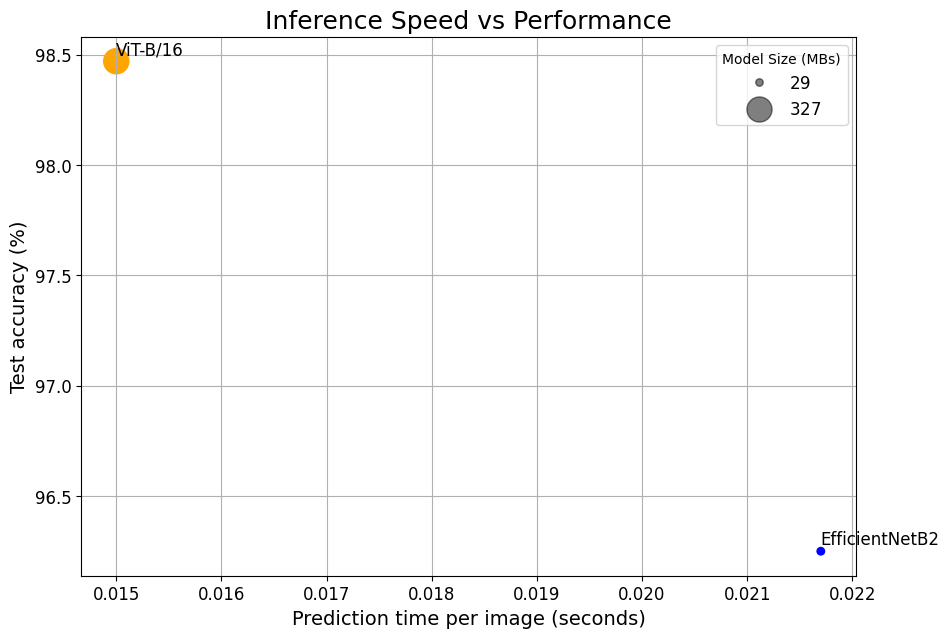

In [ ]:
# Visualizing the speed vs. performance
# Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(data=models_df,
                     x="mean_pred_time",
                     y="test_accuracy",
                     c=["blue", "orange"],
                     s="model_size")

# Add titles, labels and customize fontsize for aesthetics
ax.set_title("Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# Annotate with model names
for index, row in models_df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["mean_pred_time"], row["test_accuracy"]+0.03),
                size=12)

# Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="upper right",
                              title="Model Size (MBs)",
                              fontsize=12)

# Save the figure
plt.savefig("speed_vs_acc.jpg")

As we can see, both of the models achieved the desired mean prediction time (less than 0.03 seconds).

Since both models also achieved the desired accuracy, we will pick a model that is more suited to our use-case based off other criteria like the size of the model, its training time, etc.

We will be deploying our model on a mobile device and / or web browser, and despite the fact that ViT-B/16 performes better, we will pick the slightly weaker EfficientNetB2 despite having a marginally lower accuracy and average prediction time, simply becuase it's way smaller in size and generally faster to train, which is suitable for our use case.



# Bringing the model to life with Gradio

As described on the website, Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

So basically, it is a way of deploying a demo of our model so we can test it in a real-world setting.

It replicates the workflow: **INPUTS -> ML MODEL -> OUTPUTS**

Where the INPUTS could be any type of data (in our case images), the ML MODEL is our train EfficientNetB2 feature extractor, and the OUTPUTS will be the class labels.

Food Images -> EfficientNetB2 -> Food Images Class Labels

In [16]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.4/312.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.6 MB/s eta 0:00:00
Gradio version: 4.24.0


In [17]:
# Putting our model on the cpu so that it can be deployed anywhere
# e.g. to deploying a model on a gpu in HuggingFace requires payment
effnetb2 = effnetb2.to('cpu')

In [28]:
# First we will create the main function that will be wrapped in Gradio's Interface()
# This function will map the inputs to the outputs.
# It will take an image as an input and return a tuple containing the prediction labels
# their probability, and the prediction time.
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  transformed_img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    y_logits = effnetb2(transformed_img)
    y_preds = torch.softmax(y_logits, dim = 1)
    y_label = torch.argmax(y_preds, dim = 1)
    pred_labels_probs = {class_names[i]: float(y_preds[0][i]) for i in range(len(class_names))}

  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_probs, pred_time

In [29]:
# Testing the function
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg

Prediction label and probability dictionary: 
{'pizza': 0.742755115032196, 'steak': 0.016197631135582924, 'sushi': 0.2410471886396408}
Prediction time: 0.1357 seconds


## Creating example images

These example images will can be used as inputs to the model if the user doesn't have any image ready to pass through the model

In [30]:
example_imgs = [[str(filepath)] for filepath in random.sample(test_data_paths, k = 3)]
example_imgs

[['data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg']]

## Creating an interface for the model

Now that we have all the pices ready, we can use Gradio's main high-level class Interface() to to create a web-based GUI / demo around our EffNetB2 model

In [31]:
title = 'FoodVision Mini'
description = 'An EfficientNetB2 feature extractor CV model to classify images of food as pizza, steak or sushi.'

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes = len(class_names),
                                      label = 'Prediction Probabilities'),
                             gr.Number(label = 'Prediction Time (s)')],
                    examples = example_imgs,
                    title = title,
                    description = description)

demo.launch(share = True,
            debug = False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5a156d7e91611abd0c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
